In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

In [2]:
mnist = fetch_openml(
    name= 'mnist_784', 
    parser= 'auto', 
    as_frame= False    # as DataFrame is not ideal for image data
)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
X.shape

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
def digit_plot(image_data: np.ndarray) -> None:
    image = image_data.reshape((28, 28))
    plt.imshow(image, cmap= 'binary')
    plt.axis('off')

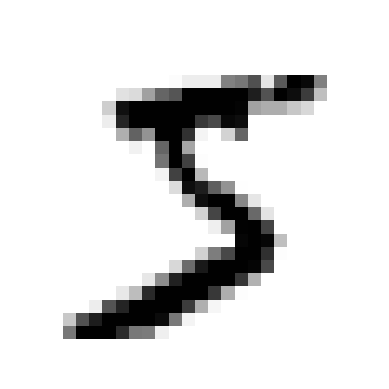

In [9]:
digit_plot(X[0])

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
A 5-detector, which tells that the given number is 5 or not.

In [11]:
y_train_5 = (y_train == '5')

In [12]:
y_test_5 = (y_test == '5')

In [13]:
sgd_classifier = SGDClassifier(random_state= 42)

In [14]:
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_classifier.predict(X_train[[0, 1]])

array([ True, False])

# Performance Measures
## Measuring using Cross Validation

In [16]:
cross_val_score(
    estimator= sgd_classifier, 
    X= X_train,
    y= y_train,
    scoring= 'accuracy',
    cv = 3
)

array([0.87365, 0.85835, 0.8689 ])

In [17]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train_5)
predictions_dummy = dummy_classifier.predict(X_train)
accuracy_score(y_train_5, predictions_dummy)

0.90965

Accuracy is not a good metric, because even a dummy classifier is getting really high accuracy just by predicting False for all data.

## Confusion Matrix

In [18]:
predictions = sgd_classifier.predict(X_train)

In [19]:
cm = confusion_matrix(y_train_5, predictions)

In [20]:
cm

array([[52316,  2263],
       [  601,  4820]])

In [21]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

## precision, recall, and f1_score

In [22]:
precision_score(y_train_5, predictions)

0.6805026118876183

In [23]:
recall_score(y_train_5, predictions)

0.8891348459693783

In [24]:
f1_score(y_train_5, predictions)

0.7709532949456175

## Working of SGDClassifier
For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class otherwise it assigns it to the negative class.

In [25]:
y_score = sgd_classifier.decision_function(X_train[[0]])

In [26]:
y_score

array([2164.22030239])

In [27]:
threshold = 0

y_score > threshold

array([ True])

In [28]:
threshold = 3000

y_score > threshold

array([False])

## The precision/recall trade-off

In [29]:
y_scores = cross_val_predict(
    estimator= sgd_classifier,
    X= X_train,
    y= y_train_5,
    cv= 3, 
    method= 'decision_function'
)

In [30]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

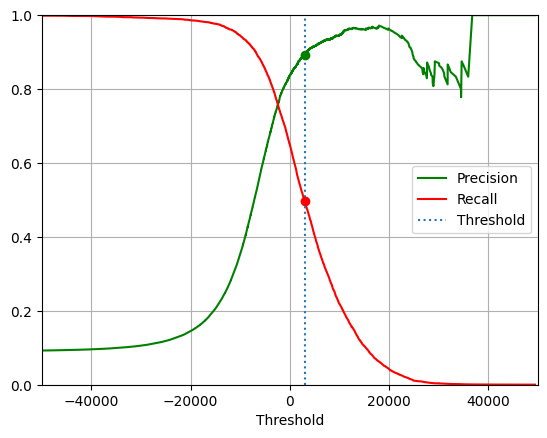

In [32]:
plt.plot(thresholds, precisions[:-1], 'g', label= 'Precision')
plt.plot(thresholds, recalls[:-1], 'r', label= 'Recall')
plt.vlines(threshold, 0, 1.0, linestyle= 'dotted', label= 'Threshold')
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], 'go')
plt.plot(thresholds[idx], recalls[idx], 'ro')
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc= 'center right')

(0.0, 1.0, 0.0, 1.0)

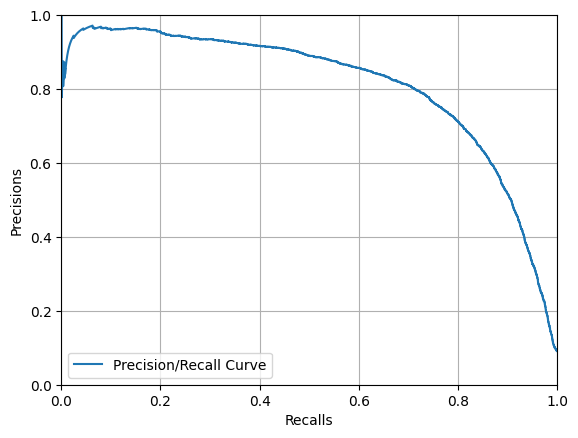

In [33]:
plt.plot(recalls, precisions, label= 'Precision/Recall Curve')
plt.ylabel('Precisions')
plt.xlabel('Recalls')
plt.grid()
plt.legend(loc= 'lower left')
plt.axis([0, 1, 0, 1])

### Selecting a particular precision/recall

In [34]:
idx_for_90_precision = (precisions >= 0.9).argmax()

In [35]:
threshold_90_precision = thresholds[idx_for_90_precision]

In [36]:
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

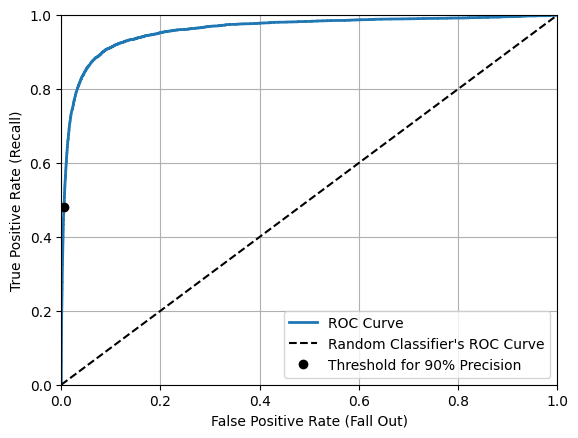

In [42]:
idx_for_threshold_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_90], fpr[idx_for_threshold_90]

plt.plot(fpr, tpr, label= 'ROC Curve', linewidth= 2)
plt.plot([0, 1], [0, 1], 'k--', label= "Random Classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], 'ko', label= 'Threshold for 90% Precision')
plt.legend()
plt.grid()
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## RandomForestClassifier

In [44]:
rnd_forest_clf = RandomForestClassifier(random_state= 42)

In [45]:
y_probas_forest = cross_val_predict(
    estimator= rnd_forest_clf,
    X= X_train,
    y= y_train_5, 
    cv= 3,
    method= 'predict_proba'
)

In [46]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [47]:
precision_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5, y_probas_forest[:, 1])

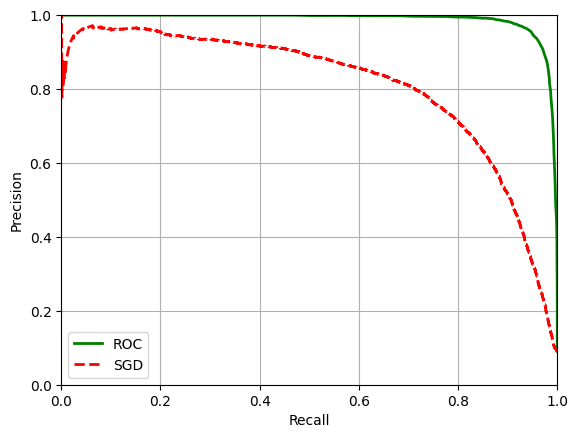

In [48]:
plt.plot(recall_forest, precision_forest, 'g', label= 'ROC', linewidth= 2)
plt.plot(recalls, precisions, 'r--', label= 'SGD', linewidth= 2)
plt.grid()
plt.legend()
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We can see that RandomForest is better then SGD

In [49]:
y_scores_forest = y_probas_forest[:, 1]
y_train_pred_forest = y_scores_forest >= 0.5

In [50]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [51]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [52]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [54]:
svc = SVC(random_state= 42)

In [55]:
svc.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [56]:
svc.predict(X_train[:10])

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [57]:
y_train[:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [58]:
first_digit_scores = svc.decision_function(X_train[[0]]).round(2)

In [59]:
first_digit_scores

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [60]:
class_id = first_digit_scores.argmax()

In [61]:
class_id

5

In [62]:
svc.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [63]:
ovr_clf = OneVsRestClassifier(SVC(random_state= 42))

In [64]:
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [65]:
ovr_clf.predict(X_train[[0]])

array(['5'], dtype='<U1')

In [66]:
len(ovr_clf.estimators_)

10

In [67]:
sgd_clf = SGDClassifier(random_state= 42)

In [68]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [69]:
sgd_clf.predict(X_train[[0]])

array(['3'], dtype='<U1')

In [70]:
sgd_clf.decision_function(X_train[[0]]).round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

## Error Analysis

In [71]:
y_train_pred = sgd_clf.predict(X_train)

Text(0.5, 1.0, 'Confusion Matrix')

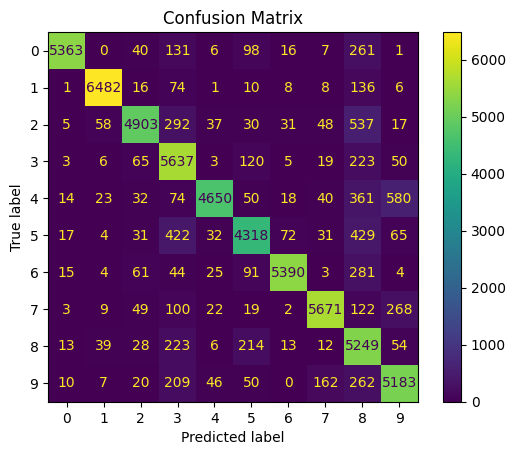

In [72]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Normalized Confusion Matrix')

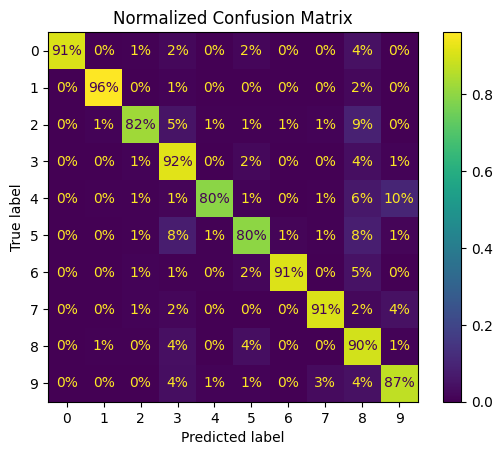

In [73]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize= 'true', values_format= '.0%')
plt.title('Normalized Confusion Matrix')

In [74]:
sample_weight = (y_train_pred != y_train)

Text(0.5, 1.0, 'Normalized errors by row')

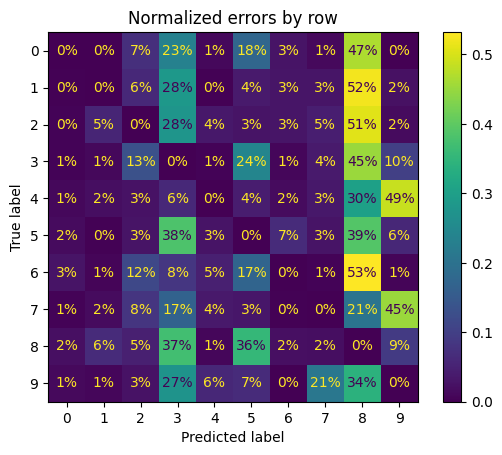

In [75]:
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    y_train_pred, 
    sample_weight= sample_weight, 
    normalize= 'true', 
    values_format= '.0%'
)
plt.title('Normalized errors by row')

Text(0.5, 1.0, 'Normalized errors by column')

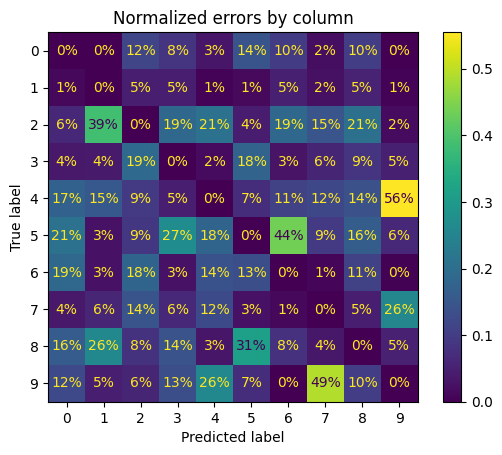

In [76]:
ConfusionMatrixDisplay.from_predictions(
    y_train, 
    y_train_pred, 
    sample_weight= sample_weight, 
    normalize= 'pred', 
    values_format= '.0%'
)
plt.title('Normalized errors by column')

# Multilabel Classification

In [77]:
y_train_large_7 = (y_train.astype('int8') >= 7)

In [78]:
y_train_odd = (y_train.astype('int8') % 2 == 1)

In [79]:
y_multilabel = np.c_[y_train_large_7, y_train_odd]

In [80]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [81]:
knn_clf = KNeighborsClassifier()

In [82]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [83]:
knn_clf.predict(X_train[[0]])

array([[False,  True]])

In [84]:
y_pred_knn = cross_val_predict(knn_clf, X_train, y_multilabel, cv= 3)

In [87]:
f1_score(y_multilabel, y_pred_knn, average= 'macro')

0.976410265560605

In [88]:
chain_clf = ClassifierChain(SVC(), cv= 3, random_state= 42)

In [89]:
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [90]:
chain_clf.predict(X_train[[0]])

array([[0., 1.]])

# Multioutput Classification

In [91]:
np.random.seed(42)

In [92]:
noise = np.random.randint(0, 100, size= (len(X_train), 784))

In [93]:
X_train_mod = X_train + noise

In [94]:
noise = np.random.randint(0, 100, size= (len(X_test), 784))

In [95]:
X_test_mod = X_test + noise

In [96]:
y_train_mod = X_train

In [97]:
y_test_mod = X_test

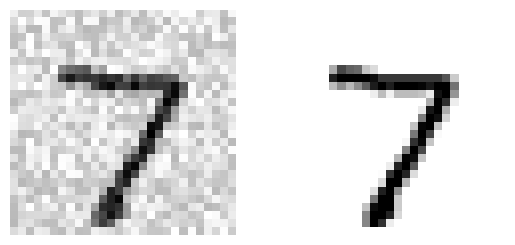

In [111]:
plt.subplot(121)     # it is like 1 row, 2 columns, and index 1
digit_plot(X_test_mod[0])
plt.subplot(122)     # it is like 1 row, 2 columns, and index 2
digit_plot(y_test_mod[0])

In [112]:
noise_remover = KNeighborsClassifier()

In [113]:
noise_remover.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [118]:
clean_img = noise_remover.predict(X_test_mod[[0]])

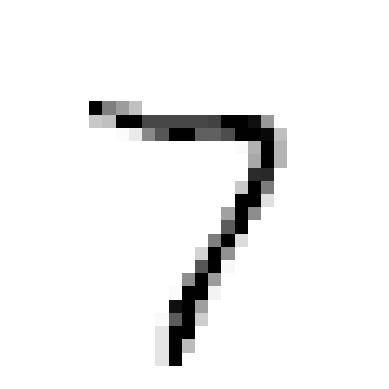

In [119]:
digit_plot(clean_img)